In [1]:
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(f'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder =  '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

Useful function for plotting a 2D dictionary

In [24]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [25]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [26]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [27]:
def compute_psnr(Y_true, Y_pred):
  mse = np.square(np.subtract(Y_true,Y_pred)).mean()
  #max_signal = np.max(Y_true)
  max_signal = 1
  return 10* np.log10(max_signal**2 / mse)

In [28]:
psnr_noisy = compute_psnr(img, noisy_img)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.12')

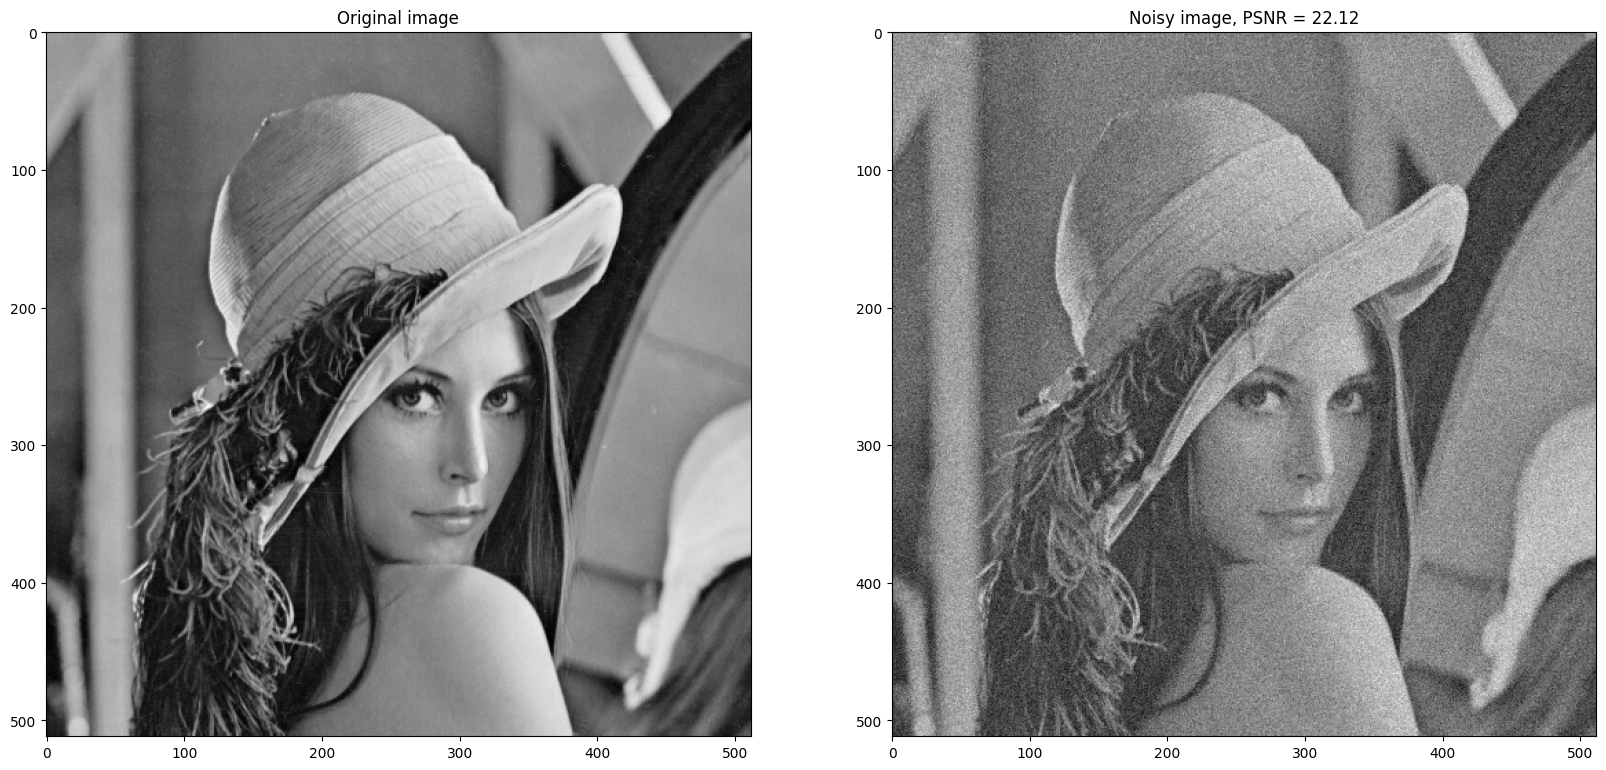

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Generate the Global PCA basis for this image
--------------------------------------------

Set the parameters for denoising

In [30]:
# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

Stack all the image patches in a large matrix $S$. Each patch goes in a column of $S$

In [31]:
# Initialize S as an empty ndarray
N = (imsz[0] - p + 1) * (imsz[1] - p + 1)
S = np.zeros((M, N))
STEP = 1
k = 0

In [32]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # Extract the patch with the top left corner at pixel (i, j)
        s_patch = noisy_img[i:i+p, j:j+p].flatten()
        # Stack the patch in the matrix S
        S[:, k] = s_patch.flatten()
        k += 1
        #S = np.append(S, np.expand_dims(s_patch, axis=1), axis=1)

print(S)
print(S.shape)

[[0.68040534 0.64605597 0.6107452  ... 0.231193   0.286058   0.34567793]
 [0.64605597 0.6107452  0.66651175 ... 0.286058   0.34567793 0.20511541]
 [0.6107452  0.66651175 0.51065479 ... 0.34567793 0.20511541 0.29510365]
 ...
 [0.64333879 0.60983359 0.62522174 ... 0.36697363 0.37661897 0.33969565]
 [0.60983359 0.62522174 0.64266046 ... 0.37661897 0.33969565 0.4411315 ]
 [0.62522174 0.64266046 0.60800977 ... 0.33969565 0.4411315  0.43473851]]
(64, 255025)


Compute $\tilde S$ by zero centering $S$


In [33]:
# Compute the column-wise average of S
avg_patch = np.mean(S, axis=0)
print(avg_patch)

[0.61939935 0.62804359 0.62227606 ... 0.3347493  0.34942297 0.36369749]


In [34]:
# Centers the matrix S at zero
Stilde = np.zeros_like(S)
for i in range(S.shape[1]):
  Stilde[:, i] = S[:, i] - avg_patch[i]
print(Stilde)

[[ 0.06100599  0.01801238 -0.01153086 ... -0.1035563  -0.06336497
  -0.01801956]
 [ 0.02665662 -0.01729838  0.04423569 ... -0.0486913  -0.00374504
  -0.15858208]
 [-0.00865415  0.03846816 -0.11162127 ...  0.01092863 -0.14430756
  -0.06859384]
 ...
 [ 0.02393944 -0.01821     0.00294568 ...  0.03222433  0.02719599
  -0.02400184]
 [-0.00956576 -0.00282184  0.0203844  ...  0.04186967 -0.00972732
   0.07743401]
 [ 0.00582239  0.01461687 -0.01426629 ...  0.00494635  0.09170853
   0.07104101]]


In [35]:
S_centered = S - avg_patch
print(S_centered)

[[ 0.06100599  0.01801238 -0.01153086 ... -0.1035563  -0.06336497
  -0.01801956]
 [ 0.02665662 -0.01729838  0.04423569 ... -0.0486913  -0.00374504
  -0.15858208]
 [-0.00865415  0.03846816 -0.11162127 ...  0.01092863 -0.14430756
  -0.06859384]
 ...
 [ 0.02393944 -0.01821     0.00294568 ...  0.03222433  0.02719599
  -0.02400184]
 [-0.00956576 -0.00282184  0.0203844  ...  0.04186967 -0.00972732
   0.07743401]
 [ 0.00582239  0.01461687 -0.01426629 ...  0.00494635  0.09170853
   0.07104101]]


In [36]:
# Check if the matrices are identical
are_identical = np.array_equal(Stilde, S_centered)
print("Matrices are identical:", are_identical)

Matrices are identical: True


Compute the PCA transformation via SVD


In [37]:
U, Sigma, V = np.linalg.svd(np.dot(Stilde, Stilde.T), full_matrices=False)

Show the learned PCA basis

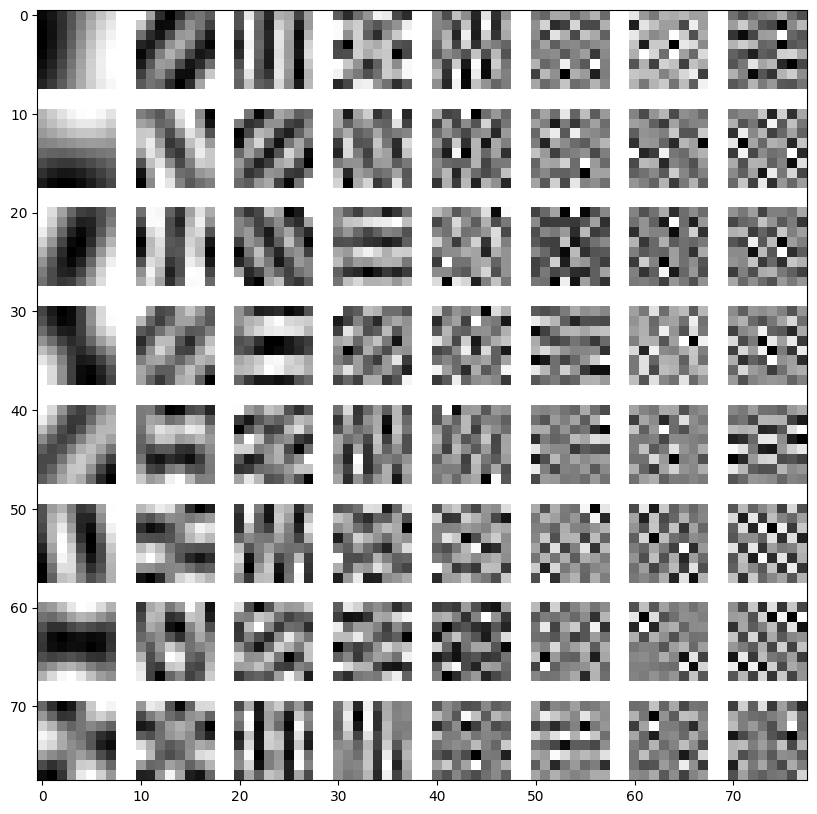

In [38]:
U_img = get_dictionary_img(U)
plt.figure(figsize=(10,10))
plt.imshow(U_img, cmap='gray')


Patch-based denoising
---------------------
Initialize the variables

In [39]:
STEP = 1

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [40]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].reshape((M,))

        # Preprocessing: remember to subtract the avg_patch (preprocessing used for PCA)
        noisy_patch_avg = np.mean(s)
        s = s - noisy_patch_avg

        # compute the representation w.r.t. the PCA basis
        x_hat = np.dot(U.T, s)

        # perform the hard thresholding
        x_hat = np.where(np.abs(x_hat) < tau, 0, x_hat)

        # synthesis: perform the reconstruction
        y_hat = np.dot(U, x_hat)

        # add the avg patch back
        y_hat = (y_hat + noisy_patch_avg).reshape((p, p))

        # compute the weight for the reconstructed patch
        w = 1

        # put the denoised patch into the denoised image using the computed weight
        # UPDATE img_hat
        img_hat[i:i+p, j:j+p] = img_hat[i:i+p, j:j+p] + w * y_hat

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p, j:j+p] = weights[i:i+p, j:j+p] + w

# normalize the estimated image with the computed weights
img_hat = img_hat / weights


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 32.13')

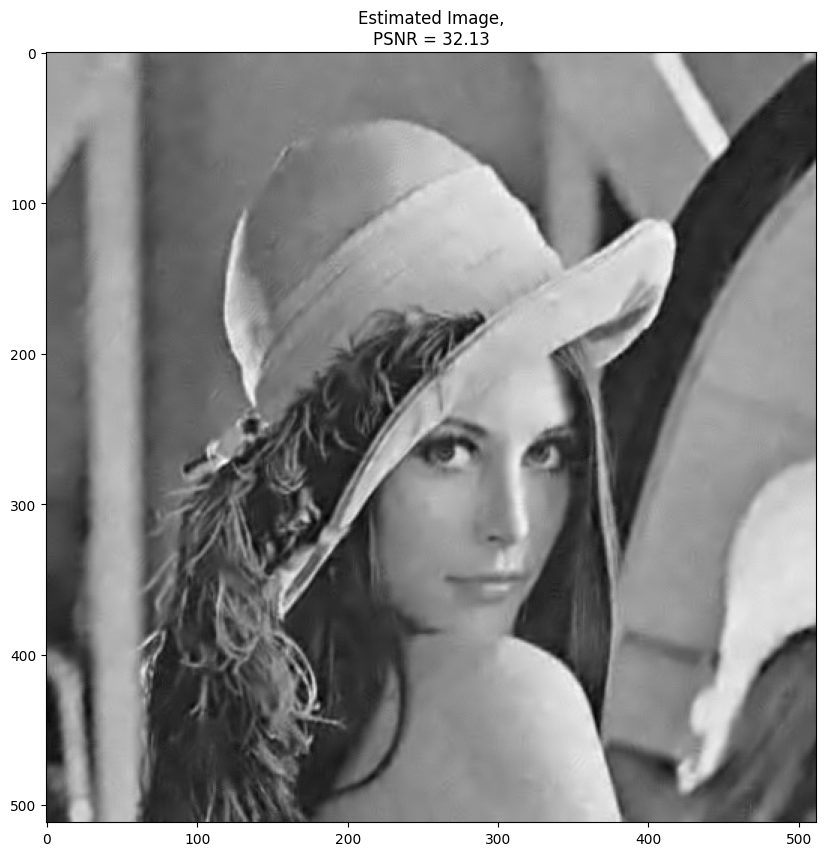

In [41]:
psnr_hat = compute_psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
